# SAP and PDCSAP photometry 

SAP flux = Simple Aperture Photometry flux, the flux after summing the calibrated pixels within the TESS optimal photometric aperture. By carefully choosing the shape of the aperture mask, you can avoid nearby contaminants or improve the strength of the specific signal you are trying to measure relative to the background.

PDCSAP Flux = Pre-search Data Conditioned Simple Aperture Photometry, the SAP flux values nominally corrected for instrumental variations. Thus, these fluxes are the mission's best estimate of the intrinsic variability of the target.

Pre-search Data Conditioning SAP flux is stored in a TESSLightCurveFile object.  Rather than being generated via a TPF, these objects have been pre-generated using NASA’s Data Processing Pipeline. Usually, you will access these files through the MAST archive.

The TESS Science Processing Operations Center - Jon M Jenkins, SPIE 2016
Abstract: https://ui.adsabs.harvard.edu/abs/2016SPIE.9913E..3EJ/abstract
PDF: https://heasarc.gsfc.nasa.gov/docs/tess/docs/jenkinsSPIE2016-copyright.pdf

With PDCSAP flux long term trends have been removed from the data using so-called Co-trending Basis Vectors (CBVs). PDCSAP flux is usually cleaner data than the SAP flux and will have fewer systematic trends.




In [1]:
%matplotlib notebook 
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt

In [2]:
sector20_lcf = "MAST_2021-10-14T1301/TESS/tess2019357164649-s0020-0000000356473034-0165-s/tess2019357164649-s0020-0000000356473034-0165-s_lc.fits"

In [5]:
fits.info(sector20_lcf)
lchdu = fits.open(sector20_lcf)


Filename: MAST_2021-10-14T1301/TESS/tess2019357164649-s0020-0000000356473034-0165-s/tess2019357164649-s0020-0000000356473034-0165-s_lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    167   18954R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   


In [15]:
lchdu[1].columns


ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; u

In [16]:
lcf_data = lchdu[1].data


In [13]:
time_bjd = lcf_data["TIME"]
lcf_head = lchdu[1].header
bjd_ref = lcf_head['BJDREFI'] + lcf_head['BJDREFF']

print("TESS JD Offset is: %f" % bjd_ref)

TESS JD Offset is: 2457000.000000


In [19]:
time_bjd = lcf_data['TIME'] + bjd_ref

sap_flux = lcf_data['SAP_FLUX']
sap_flux_err = lcf_data['SAP_FLUX_ERR']
pdcsap_flux = lcf_data['PDCSAP_FLUX']
pdcsap_flux_err = lcf_data['PDCSAP_FLUX_ERR']

<IPython.core.display.Javascript object>


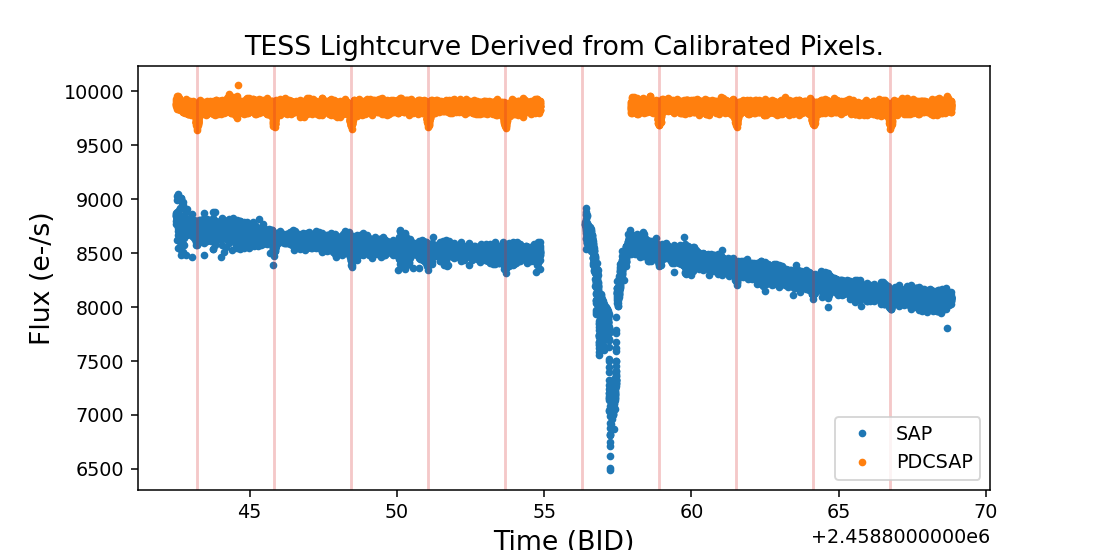

In [20]:
plt.figure(figsize = (8,4))
plt.plot(time_bjd, sap_flux,'.', label = 'SAP', ms = 6)
plt.plot(time_bjd, pdcsap_flux,'.', label = 'PDCSAP', ms = 6)

for ii in range(0,10):
    plt.axvline(2458843.218679 + 2.61582557385023*ii, c='C3', alpha=0.25)

plt.legend()
plt.xlabel('Time (BJD)', fontsize = 14)
plt.ylabel('Flux (e-/s)', fontsize = 14)
plt.title("TESS Lightcurve Derived from Calibrated Pixels.", fontsize = 14)
plt.show()

In [21]:
print('Number of    SAP epochs:', np.shape(sap_flux))
print('Number of PDCSAP epochs:', np.shape(pdcsap_flux))

Number of    SAP epochs: (18954,)
Number of PDCSAP epochs: (18954,)


In [28]:
sel = (np.abs(time_bjd-2458857) < 0.2)
print(pdcsap_flux[sel])

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan na

In [34]:
quality = lcf_data['QUALITY']


bits_to_be_checked = np.array([1,2,3,4,5,6,8,10,12,13])
value = 0
for v in bits_to_be_checked:
    value = value + 2**(v-1)

print(value)
print(quality[3])
print()
print('{0:16d}'.format(int(np.binary_repr(value))))
print('{0:16d}'.format(int(np.binary_repr(quality[3]))))


bad_data = (np.bitwise_and(quality, value) >= 1) & (np.isnan(pdcsap_flux))
# those are the points to be removed

print(bad_data[3])

good_data = ~bad_data


6847
32

   1101010111111
          100000
True


<IPython.core.display.Javascript object>


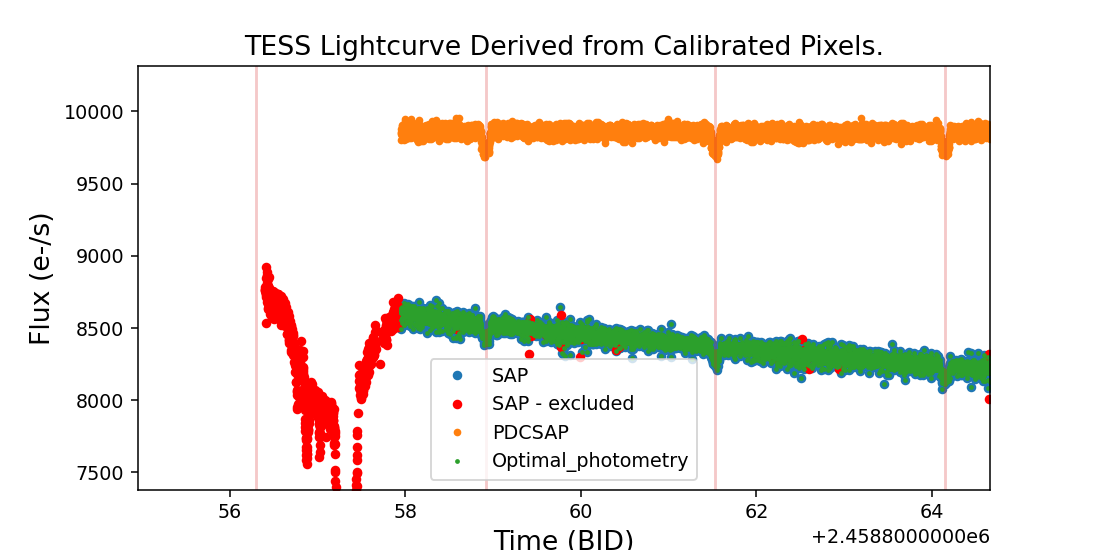

In [36]:
optimal_phot_data = np.genfromtxt('XO2N_optimal_aperture.dat')

plt.figure(figsize = (8,4))
plt.plot(time_bjd[good_data], sap_flux[good_data],'.', label = 'SAP', ms = 8)
plt.plot(time_bjd[bad_data], sap_flux[bad_data],'.', label = 'SAP - excluded', c='r', ms = 8)

plt.plot(time_bjd[good_data], pdcsap_flux[good_data],'.', label = 'PDCSAP', ms = 6)
plt.plot(optimal_phot_data[:,0], optimal_phot_data[:,1],'.', label = 'Optimal_photometry', ms = 3)

for ii in range(0,10):
    plt.axvline(2458843.218679 + 2.61582557385023*ii, c='C3', alpha=0.25)

plt.legend()
plt.xlabel('Time (BJD)', fontsize = 14)
plt.ylabel('Flux (e-/s)', fontsize = 14)
plt.title("TESS Lightcurve Derived from Calibrated Pixels.", fontsize = 14)
plt.show()

In [37]:
fileout = open('XO2N_SAPflux.dat', 'w')

for b,v,e in zip(time_bjd[good_data], 
                 sap_flux[good_data], 
                 sap_flux_err[good_data]):
    fileout.write('{0:16f} {1:16f} {2:16f}\n'.format(b,v,e))
fileout.close()

fileout = open('XO2N_PDCSAPflux.dat', 'w')

for b,v,e in zip(time_bjd[good_data], 
                 pdcsap_flux[good_data], 
                 pdcsap_flux_err[good_data]):
    fileout.write('{0:16f} {1:16f} {2:16f}\n'.format(b,v,e))
fileout.close()